# Yulu : Hypothesis Testing

## 1 Overview

### 1.1 Problem Statement

#### About Yulu

Yulu is India's leading micro-mobility service provider, which offers unique vehicles for the daily commute. Starting off as a mission to eliminate traffic congestion in India, Yulu provides the safest commute solution through a user-friendly mobile app to enable shared, solo and sustainable commuting.

Yulu zones are located at all the appropriate locations (including metro stations, bus stands, office spaces, residential areas, corporate offices, etc) to make those first and last miles smooth, affordable, and convenient!

#### Business Problem

Yulu has recently suffered considerable dips in its revenues. They want to understand the factors on which the demand for these shared electric cycles depends.  
Specifically, they want to understand the factors affecting the demand for these shared electric cycles in the Indian market.

### 1.2 About Dataset

#### Features

- `datetime`: date and time
- `season`: seasons:
    - 1: spring
    - 2: summer
    - 3: fall
    - 4: winter
- `holiday`: Whether day is a holiday or not
- `workingday`: If day is neither weekend nor holiday is 1, otherwise is 0.
- `weather`:
    - 1: Clear, Few clouds, partly cloudy, partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- `temp`: Temperature in Celsius
- `atemp`: Feeling temperature in Celsius
- `humidity`: Humidity
- `windspeed`: Wind speed
- `casual`: Count of casual users
- `registered`: Count of registered users
- `count`: Count of total rental bikes including both casual and registered

### 1.3 Objective

Objective of this notebook:

1. To perform EDA on the given Dataset.
2. Perform Hypothesis testing to identify key features affecting the target variable.
3. Answer some questions:
    1. Which variables are significant in predicting the demand for shared electric cycles in the Indian market?
    2. How well those variables describe the electric cycle demands

## 2 Setup

### 2.1 Libraries

#### Import Libraries

In [1]:
# Data manipulation libraries.
import numpy as np
import pandas as pd

# Data visualization libraries.
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Hypothesis testing functions.
from scipy.stats import ttest_ind, shapiro, levene, f_oneway, kruskal, chi2_contingency


print("NumPy version:", np.__version__)
print("Pandas version:", pd.__version__)
print("Matplotlib version:", matplotlib.__version__)
print("Seaborn version:", sns.__version__)

NumPy version: 2.3.4
Pandas version: 2.3.3
Matplotlib version: 3.10.7
Seaborn version: 0.13.2


#### Configure Libraries

In [2]:
# Configure NumPy.
np.random.seed(42)

# Configure Seaborn.
sns.set_style("whitegrid")
sns.set_palette("deep")

#### Helper functions

In [3]:
def counts_n_proportions(series, n=5):
    """
    Function to display value counts and percentages.
    """
    count_df = series.value_counts()
    percent_df = series.value_counts(normalize=True).multiply(100).round(2)
    res_df = pd.concat([count_df, percent_df], axis=1)
    res_df.columns = ["Count", "Percentage"]

    display(res_df)

In [4]:
def is_weekend(date_name):
    """
    Function to ckeck is week day is weekend.
    """
    return 1 if date_name in ["Sunday", "Saturday"] else 0

In [5]:
def shapiro_test(sample, alpha=0.05):
    """
    Function to perform Shapiro-Willkis test on input `sample`.
    """
    test_stat, p_value = shapiro(sample)
    print("W-statistic:", test_stat.item())
    print("p-value:", p_value.item())

    if p_value < alpha:
        print("Reject Null-Hypothesis. Distribution is not Gaussian.")
    else:
        print("Failed to reject Null-Hypothesis. Distribution is Gaussian.")

In [6]:
def levene_test(*samples, alpha=0.05):
    """
    Function to perform Shapiro-Willkis test on input `sample`.
    """
    test_stat, p_value = levene(*samples)
    print("Test-statistic:", test_stat.item())
    print("p-value:", p_value.item())

    # STEP 5: Compare p-value with alpha
    if p_value < alpha:
        print("Reject Null-Hypothesis. At least one of the sample has different Variance.")
    else:
        print("Failed to reject Null-Hypothesis. Variances of all the samples are equal.")

### 2.2 Dataset

#### Import DataSet

In [7]:
yu_df = pd.read_csv("data/bike_sharing.csv")
row_count, col_count = yu_df.shape

print(f"Dataset has {row_count} rows and {col_count} columns")

Dataset has 10886 rows and 12 columns


In [8]:
yu_df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32


##### Observations

Dataset contains details of approximately 10,000 bike rental details of casual and registered customers.

### 2.3 Data Profiling

In [9]:
yu_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


#### 1 Feature types

##### Categorical Features

1. season (Multi-class)
2. holiday (Binary)
3. workingday (Binary)
4. weather (Multi-class)

##### Numerical Features

1. temp
2. atemp
3. humidity
4. windspeed
5. casual
6. registered
7. count

#### 2 Cardinality

In [10]:
yu_df.nunique().sort_values(ascending=False)

datetime      10886
count           822
registered      731
casual          309
humidity         89
atemp            60
temp             49
windspeed        28
season            4
weather           4
workingday        2
holiday           2
dtype: int64

## 3 Data Wrangling

### 3.1 Data Validation

#### 1 Handling Missing Values

In [11]:
yu_df.isna().sum().reset_index(name="count")

,index,count
0,datetime,0
1,season,0
2,holiday,0
3,workingday,0
4,weather,0
5,temp,0
6,atemp,0
7,humidity,0
8,windspeed,0
9,casual,0


In [12]:
mask = yu_df["casual"] == 0
len(yu_df[mask])

986

In [13]:
mask = yu_df["registered"] == 0
len(yu_df[mask])

15

In [14]:
mask = (yu_df["casual"] == 0) & (yu_df["registered"] == 0)
yu_df[mask]

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count


In [15]:
mask = yu_df["count"] == 0
yu_df[mask]

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count


##### Observations

1. All the features have zero missing values.
2. Dataset does not contain any missing values.

#### 2 Duplicate check

In [16]:
mask = yu_df.duplicated()
yu_df[mask]

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count


##### Observations

Dataset does not contain any duplicate values.

### 3.2 Handling Outliers

In [17]:
def detect_outliers(df: pd.DataFrame, col_name: str):
    # Get 25th percentile.
    Q1 = df[col_name].quantile(0.25)

    # Get 75th percentile.
    Q3 = df[col_name].quantile(0.75)

    # Get IQR value.
    IQR = Q3 - Q1

    # Calculate lower and upper bound.
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter out outliers using mask and return final result
    mask = (df[col_name] >= lower_bound) & (df[col_name] <= upper_bound)

    out_count, _ = yu_df[~mask].shape
    out_per = (out_count / row_count) * 100
    out_per = round(out_per, 2)

    return ~mask, out_count, out_per

In [18]:
out_mask, out_count, out_per = detect_outliers(yu_df, "temp")

print(f"{out_count} rows are outliers.")
print(f"{out_per}% of data are outliers.")

0 rows are outliers.
0.0% of data are outliers.


In [19]:
out_mask, out_count, out_per = detect_outliers(yu_df, "atemp")

print(f"{out_count} rows are outliers.")
print(f"{out_per}% of data are outliers.")

0 rows are outliers.
0.0% of data are outliers.


In [20]:
out_mask, out_count, out_per = detect_outliers(yu_df, "humidity")

print(f"{out_count} rows are outliers.")
print(f"{out_per}% of data are outliers.")

22 rows are outliers.
0.2% of data are outliers.


In [21]:
yu_df = yu_df[~out_mask]
yu_df.shape

(10864, 12)

In [22]:
out_mask, out_count, out_per = detect_outliers(yu_df, "windspeed")

print(f"{out_count} rows are outliers.")
print(f"{out_per}% of data are outliers.")

226 rows are outliers.
2.08% of data are outliers.


In [23]:
yu_df = yu_df[~out_mask]
yu_df.shape

(10638, 12)

In [24]:
out_mask, out_count, out_per = detect_outliers(yu_df, "casual")

print(f"{out_count} rows are outliers.")
print(f"{out_per}% of data are outliers.")

737 rows are outliers.
6.77% of data are outliers.


In [25]:
yu_df = yu_df[~out_mask]
yu_df.shape

(9901, 12)

In [26]:
out_mask, out_count, out_per = detect_outliers(yu_df, "registered")

print(f"{out_count} rows are outliers.")
print(f"{out_per}% of data are outliers.")

518 rows are outliers.
4.76% of data are outliers.


In [27]:
yu_df = yu_df[~out_mask]
yu_df.shape

(9383, 12)

In [28]:
out_mask, out_count, out_per = detect_outliers(yu_df, "count")

print(f"{out_count} rows are outliers.")
print(f"{out_per}% of data are outliers.")

19 rows are outliers.
0.17% of data are outliers.


In [29]:
yu_df = yu_df[~out_mask]
final_row_count, _ = yu_df.shape
(final_row_count, _)

(9364, 12)

In [30]:
data_loss = round((row_count - final_row_count) / row_count * 100)
print(f"{data_loss}% of outliers in data were deleted.")

14% of outliers in data were deleted.


### 3.3 Transforming

#### Feature `datetime`

Transform feature `datetime` string into pandas datetime datatype.

In [31]:
yu_df["datetime"] = pd.to_datetime(yu_df["datetime"].str.strip(), format="%Y-%m-%d %H:%M:%S")
yu_df["datetime"].head(3)

0   2011-01-01 00:00:00
1   2011-01-01 01:00:00
2   2011-01-01 02:00:00
Name: datetime, dtype: datetime64[ns]

Extract `date` feature from `datetime` feature.

In [32]:
yu_df["date"] = yu_df["datetime"].dt.date

#### Convert to categorical features

In [33]:
yu_df["season"] = yu_df["season"].astype("category")
yu_df["holiday"] = yu_df["holiday"].astype("category")
yu_df["workingday"] = yu_df["workingday"].astype("category")
yu_df["weather"] = yu_df["weather"].astype("category")

In [34]:
yu_df["weekend"] = yu_df["datetime"].dt.day_name().apply(is_weekend)
yu_df["weekend"].value_counts()

weekend
0    6891
1    2473
Name: count, dtype: int64

## 4 Univariate Analysis

### 4.1 Categorical

#### Feature `weather`

In [35]:
counts_n_proportions(yu_df["weather"])

,Count,Percentage
weather,,
1,6059,64.71
2,2533,27.05
3,771,8.23
4,1,0.01


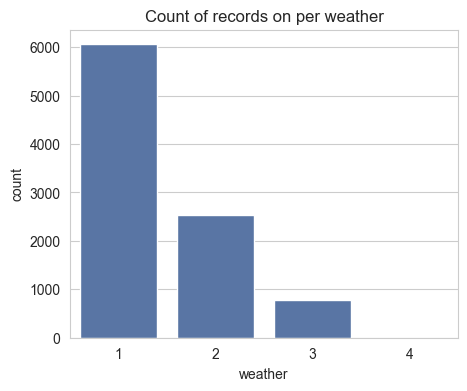

In [36]:
plt.figure(figsize=(5, 4))
sns.countplot(data=yu_df, x="weather")
plt.title("Count of records on per weather")
plt.show()

##### Observations

1. 65% of rentals recorded clear weather with few clouds.
2. 27% of rentals recorded misty and cloudy weather.
3. 8% of rentals recorded snow, rain and/or thunderstorm.
4. less than 1% of rentals recorded harsh weather conditions.

#### Feature `season`

In [37]:
counts_n_proportions(yu_df["season"])

,Count,Percentage
season,,
1,2448,26.14
4,2437,26.03
2,2249,24.02
3,2230,23.81


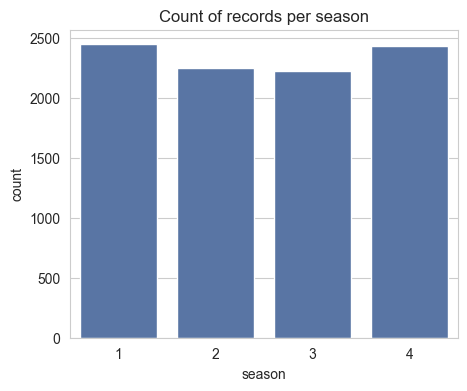

In [38]:
plt.figure(figsize=(5, 4))
sns.countplot(data=yu_df, x="season")
plt.title("Count of records per season")

plt.show()

##### Observations

1. On an average approximately 2200 plus bikes are rented every season.
2. Rental bikes have constant demand in every season.

#### Feature `holiday`

In [39]:
counts_n_proportions(yu_df["holiday"])

,Count,Percentage
holiday,,
0,9113,97.32
1,251,2.68


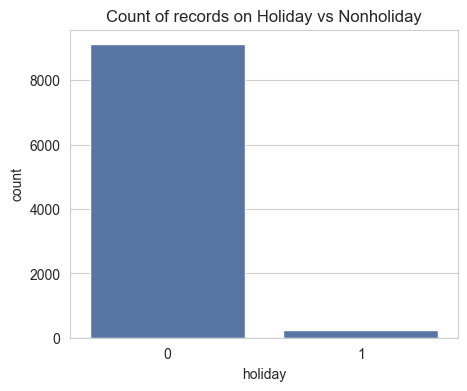

In [40]:
plt.figure(figsize=(5, 4))
sns.countplot(data=yu_df, x="holiday")
plt.title("Count of records on Holiday vs Nonholiday")
plt.show()

##### Observations

1. 97% of bike rentals happen on non holidays.
2. Only 3% of bike rentals happen on holidays.

#### Feature `workingday`

In [41]:
counts_n_proportions(yu_df["workingday"])

,Count,Percentage
workingday,,
1,6640,70.91
0,2724,29.09


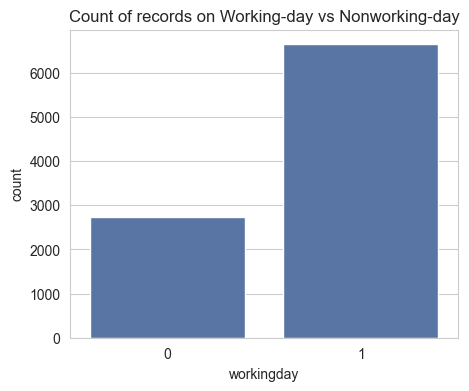

In [42]:
plt.figure(figsize=(5, 4))
sns.countplot(data=yu_df, x="workingday")
plt.title("Count of records on Working-day vs Nonworking-day")
plt.show()

##### Observations

1. 71% of rentals were recorded on working day
2. 29% of rentals were recorded on weekends or holidays.

### 4.2 Numerical

#### Feature `datetime`

In [43]:
start_date = yu_df["datetime"].min()
end_date = yu_df["datetime"].max()

print("Start date:", start_date)
print("End date:", end_date)

Start date: 2011-01-01 00:00:00
End date: 2012-12-19 23:00:00


#### Feature `temp`

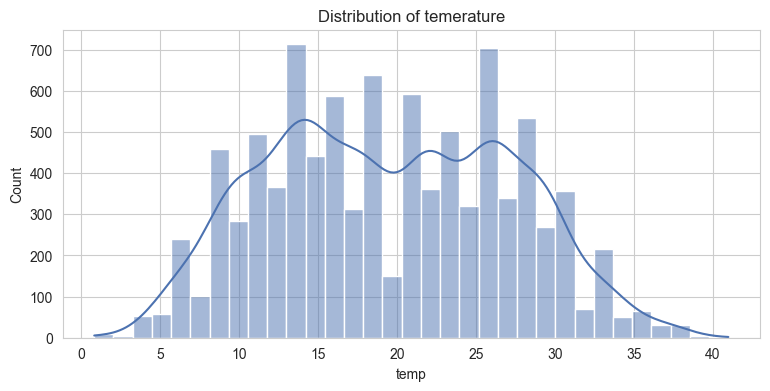

In [44]:
plt.figure(figsize=(9, 4))
sns.histplot(data=yu_df, x="temp", kde=True)
plt.title("Distribution of temerature")
plt.show()

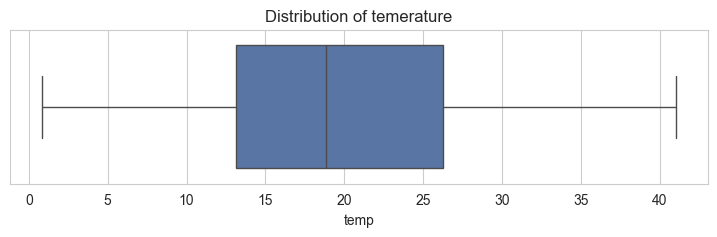

In [45]:
plt.figure(figsize=(9, 2))
sns.boxplot(data=yu_df, x="temp")
plt.title("Distribution of temerature")
plt.show()

##### Observations

Distribution of Temperature is multi-modal, mostly between 13 and 14 degree or 25 and 26 degree.

#### Feature `atemp`

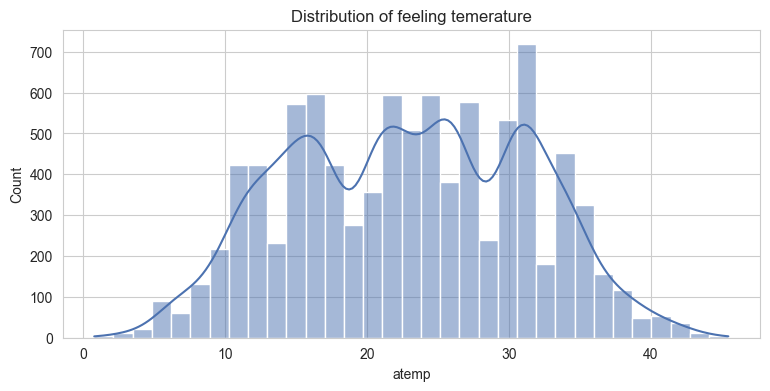

In [46]:
plt.figure(figsize=(9, 4))
sns.histplot(data=yu_df, x="atemp", kde=True)
plt.title("Distribution of feeling temerature")
plt.show()

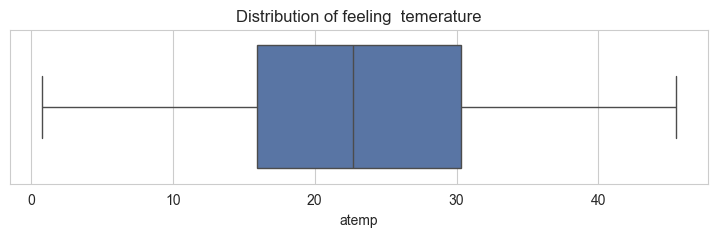

In [47]:
plt.figure(figsize=(9, 2))
sns.boxplot(data=yu_df, x="atemp")
plt.title("Distribution of feeling  temerature")
plt.show()

#### Feature `humidity`

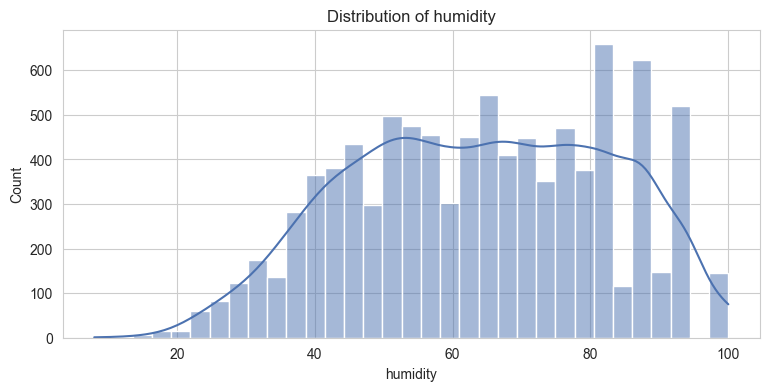

In [48]:
plt.figure(figsize=(9, 4))
sns.histplot(data=yu_df, x="humidity", kde=True)
plt.title("Distribution of humidity")
plt.show()

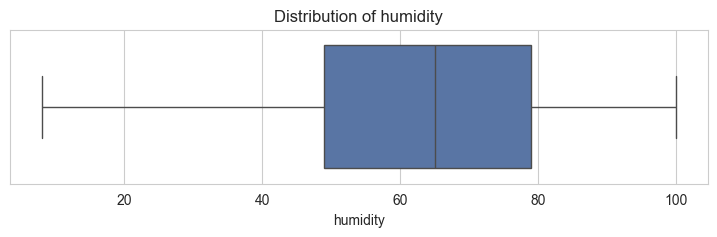

In [49]:
plt.figure(figsize=(9, 2))
sns.boxplot(data=yu_df, x="humidity")
plt.title("Distribution of humidity")
plt.show()

#### Feature `windspeed`

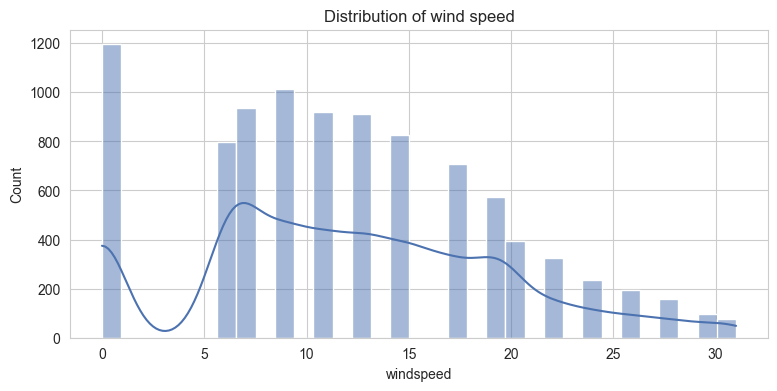

In [50]:
plt.figure(figsize=(9, 4))
sns.histplot(data=yu_df, x="windspeed", kde=True)
plt.title("Distribution of wind speed")
plt.show()

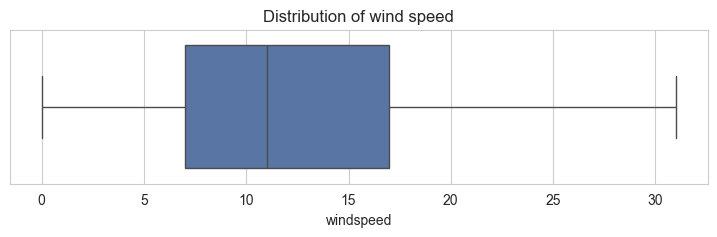

In [51]:
plt.figure(figsize=(9, 2))
sns.boxplot(data=yu_df, x="windspeed")
plt.title("Distribution of wind speed")
plt.show()

#### Feature `casual`

In [52]:
yu_df["casual"].describe()

count    9364.000000
mean       23.464438
std        26.630455
min         0.000000
25%         3.000000
50%        12.000000
75%        36.000000
max       116.000000
Name: casual, dtype: float64

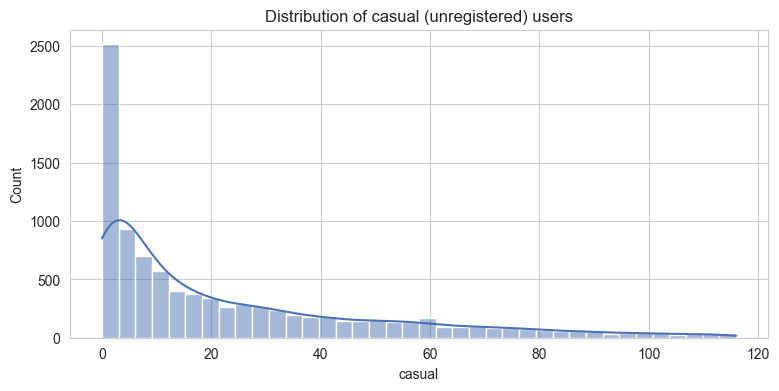

In [53]:
plt.figure(figsize=(9, 4))
sns.histplot(data=yu_df, x="casual", kde=True)
plt.title("Distribution of casual (unregistered) users")
plt.show()

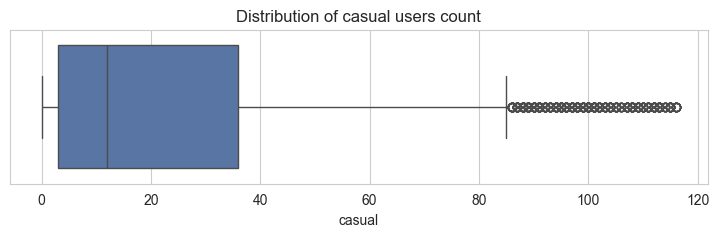

In [54]:
plt.figure(figsize=(9, 2))
sns.boxplot(data=yu_df, x="casual")
plt.title("Distribution of casual users count")
plt.show()

#### Feature `registered`

In [55]:
yu_df["registered"].describe()

count    9364.000000
mean      120.475758
std       105.924814
min         0.000000
25%        28.000000
50%        99.000000
75%       182.000000
max       458.000000
Name: registered, dtype: float64

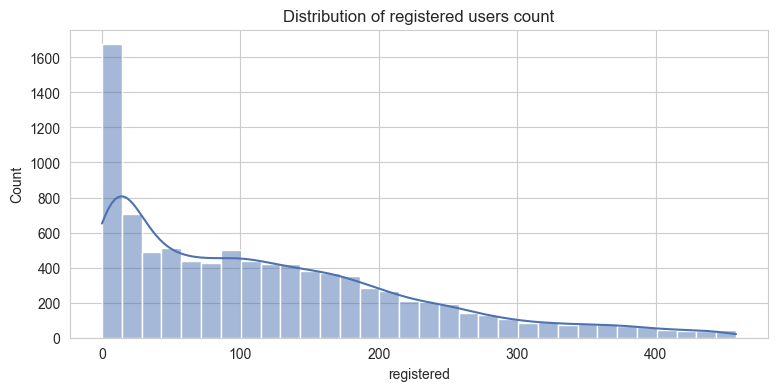

In [56]:
plt.figure(figsize=(9, 4))
sns.histplot(data=yu_df, x="registered", kde=True)
plt.title("Distribution of registered users count")
plt.show()

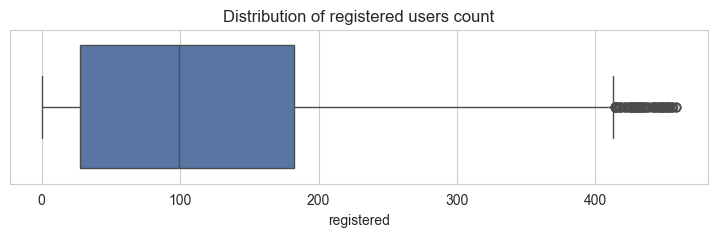

In [57]:
plt.figure(figsize=(9, 2))
sns.boxplot(data=yu_df, x="registered")
plt.title("Distribution of registered users count")
plt.show()

#### Feature `count`

In [58]:
yu_df["count"].describe()

count    9364.000000
mean      143.940196
std       123.343318
min         1.000000
25%        33.000000
50%       119.000000
75%       225.000000
max       514.000000
Name: count, dtype: float64

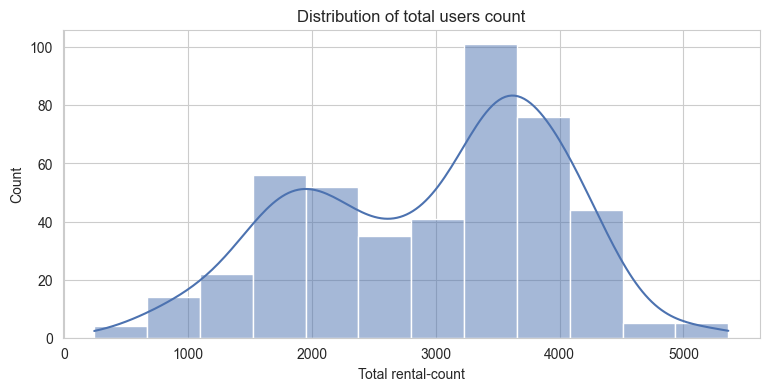

In [59]:
tot_count_df = yu_df.groupby("date").agg(tot_count=("count", "sum"))

plt.figure(figsize=(9, 4))
sns.histplot(data=tot_count_df, x="tot_count", kde=True)
plt.title("Distribution of total users count")
plt.xlabel("Total rental-count")

plt.show()

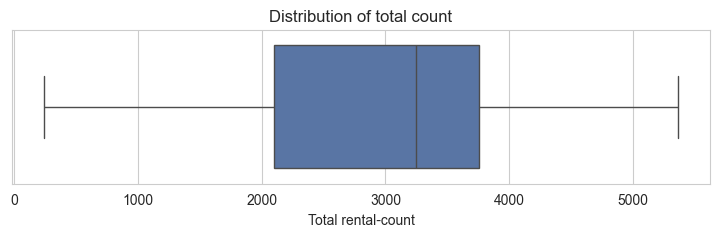

In [60]:
plt.figure(figsize=(9, 2))
sns.boxplot(data=tot_count_df, x="tot_count")
plt.title("Distribution of total count")
plt.xlabel("Total rental-count")
plt.show()

##### Observations

1. On an average 24 bikes are used by casual users in any given hour.
2. Maximum of 116 bikes gets rented by casual users in one hour.
3. On an average 120 bikes are used by registered users in any given hour.
4. Maximum of 458 bikes gets rented by registered users in one hour.
5. Overall on an average of 143 bikes are used by users in any given hour.
6. Maximum of 500 bikes gets rented by users in one hour.

## 5 Bivariate Analysis

### 5.1 Numerical vs Categorical

#### Feature `count` vs `season`

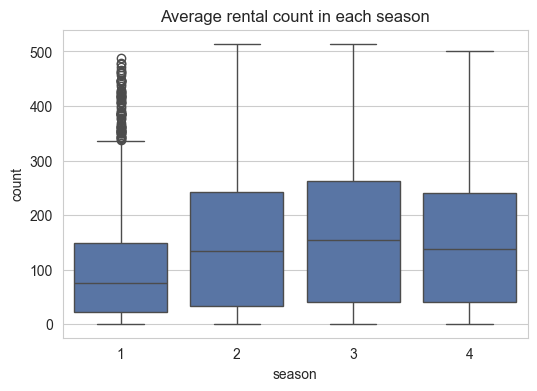

In [61]:
plt.figure(figsize=(6, 4))
sns.boxplot(data=yu_df, x="season", y="count")
plt.title("Average rental count in each season")
plt.show()

##### Observations

1. Median bike rental count appears to be same in summer, fall and winter season.
2. Median bike rental count appears to be less in spring season compared to other seasons.

#### Feature `count` vs `weather`

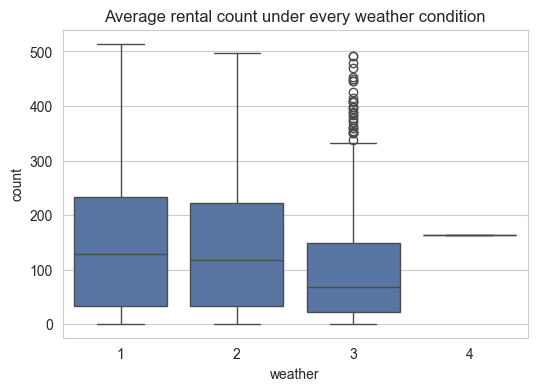

In [62]:
plt.figure(figsize=(6, 4))
sns.boxplot(data=yu_df, x="weather", y="count")
plt.title("Average rental count under every weather condition")
plt.show()

##### Observations

1. Median bike rental count appears to be same in good weather conditions like clear sky, less cloud and mist.
2. Median bike rental count appears to be less in moderate weather conditions like snowing and raining.

#### Feature `count` vs `workingday`

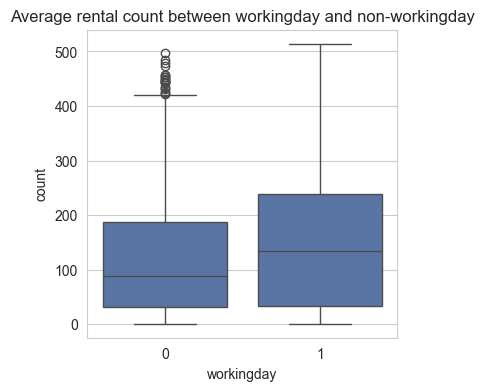

In [63]:
plt.figure(figsize=(4, 4))
sns.boxplot(data=yu_df, x="workingday", y="count")
plt.title("Average rental count between workingday and non-workingday")
plt.show()

##### Observations

Working days appears to have higher median rental count compared to non-working days.

### 5.2 Numerical vs Numerical

#### Feature `count` vs `temp`

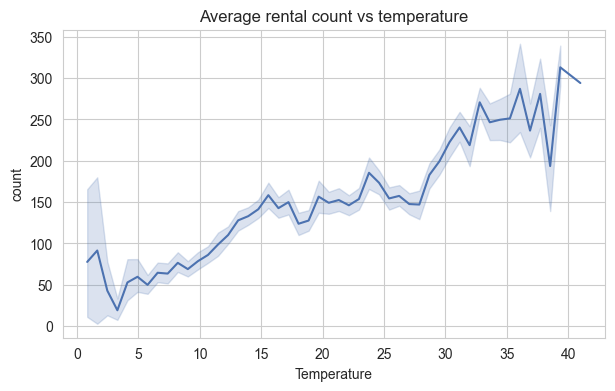

In [64]:
plt.figure(figsize=(7, 4))
sns.lineplot(data=yu_df, x="temp", y="count")
plt.title("Average rental count vs temperature")
plt.xlabel("Temperature")
plt.show()

##### Observations

As temperature increases average bike rental count increases.

#### Feature `count` vs `atemp`

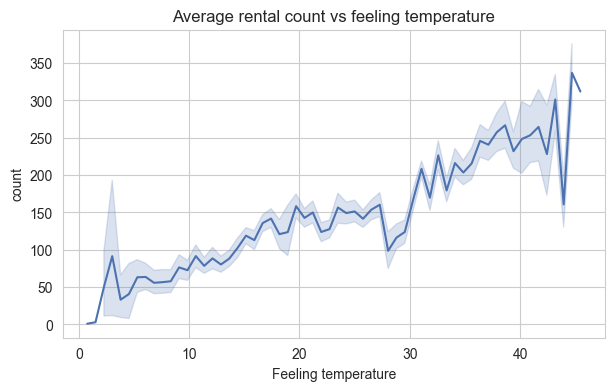

In [65]:
plt.figure(figsize=(7, 4))
sns.lineplot(data=yu_df, x="atemp", y="count")
plt.title("Average rental count vs feeling temperature")
plt.xlabel("Feeling temperature")
plt.show()

##### Observations

As temperature increases average bike rental count increases.

#### Feature `count` vs `humidity`

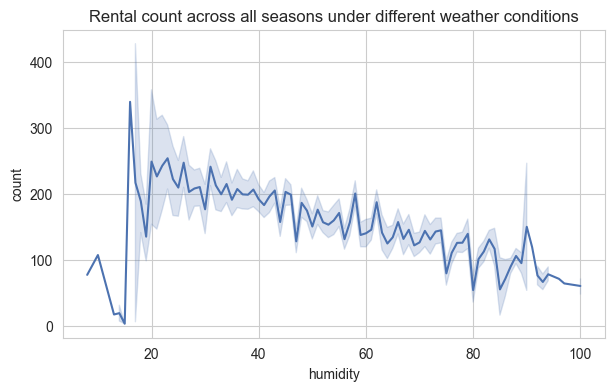

In [66]:
plt.figure(figsize=(7, 4))
sns.lineplot(data=yu_df, x="humidity", y="count")
plt.title("Rental count across all seasons under different weather conditions")
plt.show()

##### Observations

As humidity increases average bike rental count decreases.

#### Feature `count` vs `windspeed`

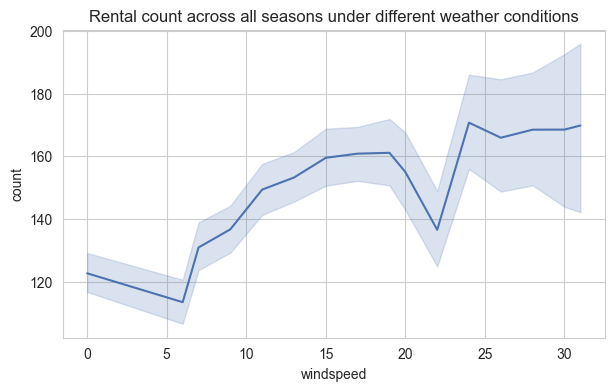

In [67]:
plt.figure(figsize=(7, 4))
sns.lineplot(data=yu_df, x="windspeed", y="count")
plt.title("Rental count across all seasons under different weather conditions")
plt.show()

In [68]:
yu_df_dt = yu_df.sort_values(by="datetime")
yu_df_dt.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,weekend
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011-01-01,1
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011-01-01,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011-01-01,1


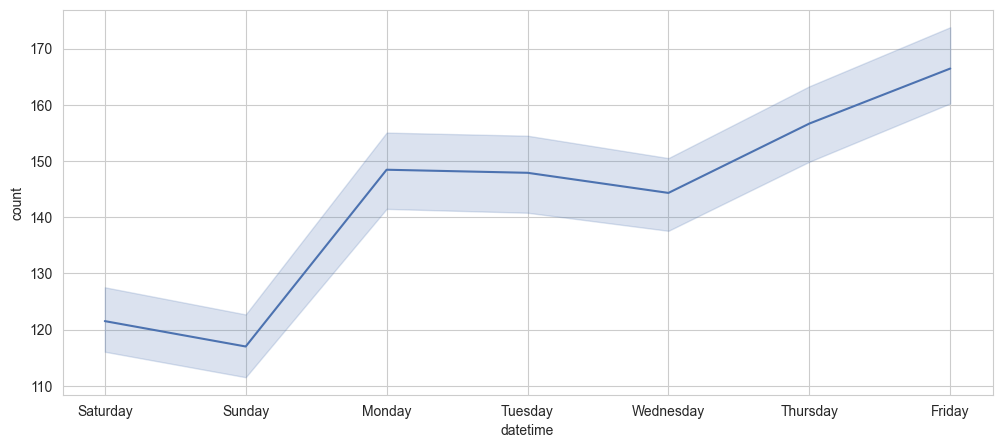

In [69]:
plt.figure(figsize=(12, 5))
sns.lineplot(data=yu_df_dt, x=yu_df_dt["datetime"].dt.day_name(), y="count")
plt.show()

## 6 Multivariate Analysis

### 6.1 Numerical vs Categorical vs Categorical

#### Features `season` vs `weather` vs `count`

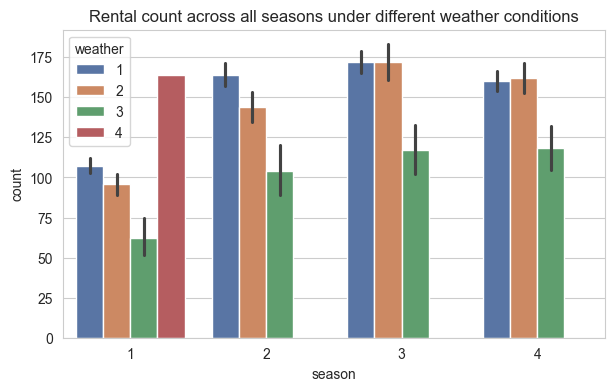

In [70]:
plt.figure(figsize=(7, 4))
sns.barplot(data=yu_df, x="season", y="count", hue="weather")
plt.title("Rental count across all seasons under different weather conditions")
plt.show()

##### Observations

1. In every season average bike rentals are high when the weather is clear and fewer clouds.
2. In every season average bike rentals are low when it is snowing or raining.
3. In Spring season, there was a very high demand on one specific day when the weather condition was very bad with heavy rain and thunderstorm.

#### Features `month` vs `day_name` vs `count`

In [71]:
mo_wdn_mx = pd.crosstab(
    index=yu_df["datetime"].dt.month,
    columns=yu_df["datetime"].dt.day_name(),
)

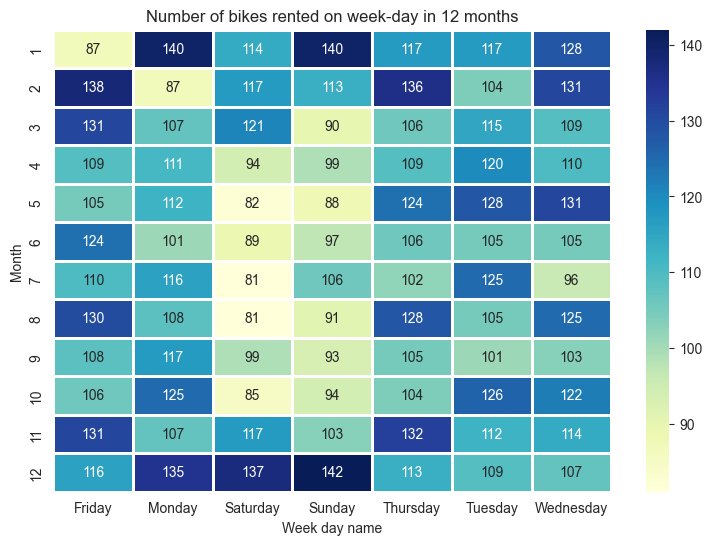

In [72]:
plt.figure(figsize=[9, 6])
sns.heatmap(mo_wdn_mx, cmap="YlGnBu", linecolor="white", linewidth=1, annot=True, fmt=".0f")
plt.xlabel("Week day name")
plt.ylabel("Month")
plt.title("Number of bikes rented on week-day in 12 months")
plt.show()

#### Features `hour` vs `day_name` vs `count`

In [73]:
mo_week_mx = pd.crosstab(
    index=yu_df["datetime"].dt.hour,
    columns=yu_df["datetime"].dt.day_name(),
)

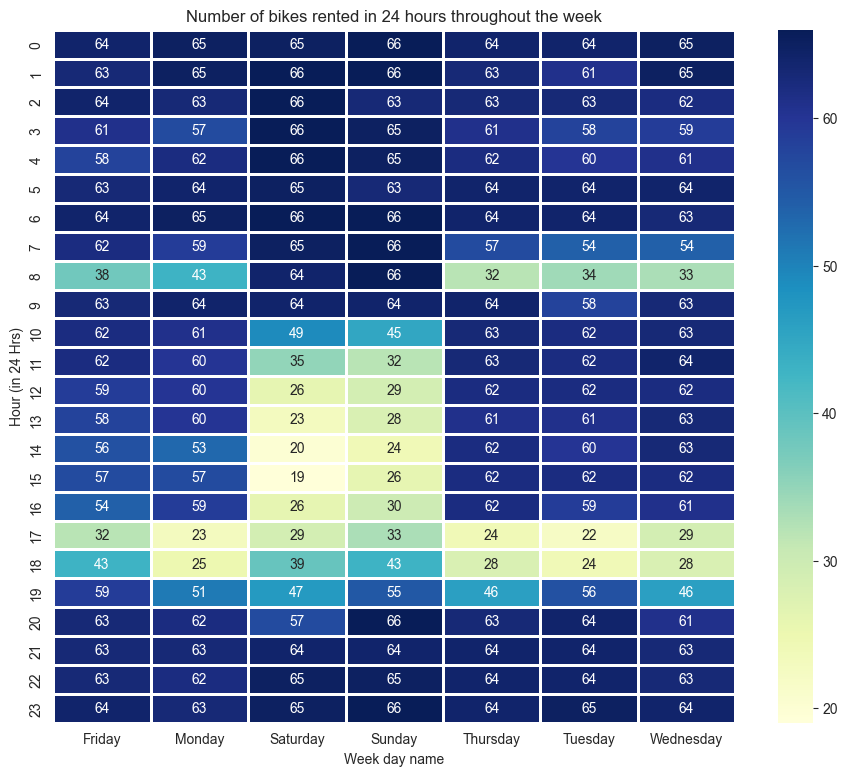

In [74]:
plt.figure(figsize=[11, 9])
sns.heatmap(mo_week_mx, cmap="YlGnBu", linecolor="white", linewidth=1, annot=True, fmt=".0f")
plt.title("Number of bikes rented in 24 hours throughout the week")
plt.xlabel("Week day name")
plt.ylabel("Hour (in 24 Hrs)")
plt.show()

##### Observations

1. On weekends demand for rental bikes is very low between 11 AM in the morning to 5 PM in the evening.
2. On weekdays demand for rental bikes is very low in two time frames:
    1. Between 8 AM and 9 AM in the morning
    2. Between 5 PM and 7 PM in the evening.

## 7 Hypothesis Testing

### 7.1 Correlation Matrix

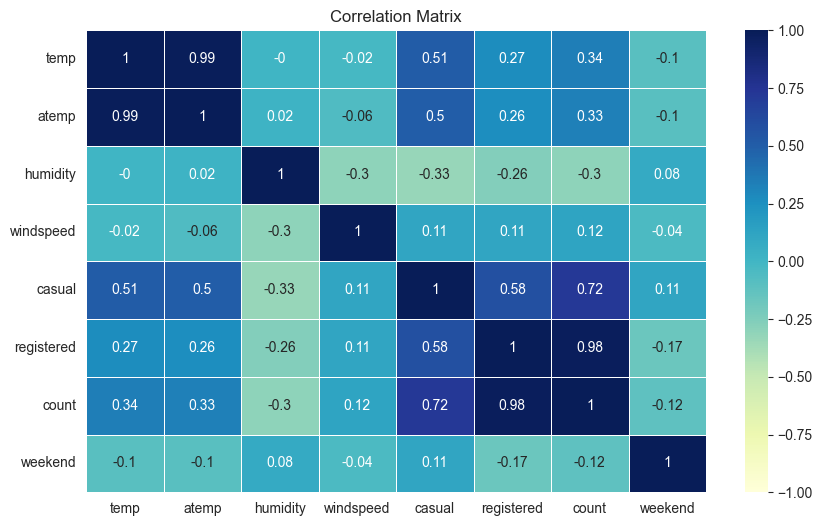

In [75]:
plt.figure(figsize=(10, 6))
corr = yu_df.corr(numeric_only=True).round(2)
sns.heatmap(corr, cmap="YlGnBu", linecolor="white", linewidth=0.5, vmin=-1, vmax=1, annot=True)
plt.title("Correlation Matrix")
plt.show()

##### Observations

1. Features `casual`, `registered` and `count` have very high positive correlation.
2. Feature `temp` and `atemp` have very high positive correlation hence one of the features can be dropped.

### 7.2 Count vs Workingday

Check if there are any significant difference between the no. of bike rides on Weekdays and Weekends?

#### Sampling

In [76]:
mask = yu_df["weekend"] == 0
wd0_count = yu_df[mask]["count"].values

mask = yu_df["weekend"] == 1
wd1_count = yu_df[mask]["count"].values

#### Independent Two-Sample T-test

##### STEP 1: Formulate Null and Alternate Hypothesis

- $H_0$ : Average number of bikes rented on weekdays is same as weekends.
- $H_a$ : Average number of bikes rented on weekdays are more compared to weekends.

Mathematically

- $H_0: \mu_1 = \mu_2$
- $H_a: \mu_1 \ne \mu_2$


Where,

1. $\mu_1$ is average number of bikes rent on weekdays.
2. $\mu_2$ is average number of bikes rent on weekends.

##### STEP 2: Select Test-statistic and Significance level

1. For Two sample Independent T-test, test-statistic is T-Statistic.
2. Significance level is set to 0.05.

In [77]:
alpha = 0.05

##### STEP 3: Select type of test: Left / Right / Two-tailed

Since we are looking for significant difference in rental-count between weekdays and weekends, we have to select two-tailed test.

##### STEP 4: Calculate test Statistics and p-value

In [78]:
test_stat, p_value = ttest_ind(a=wd0_count, b=wd1_count, alternative="two-sided")
print("T-statistic:", test_stat.item())
print("p-value:", p_value.item())

T-statistic: 11.69620464564846
p-value: 2.202207703298455e-31


##### STEP 5: Compare p-value with Significance level

In [79]:
if p_value < alpha:
    print("Reject Null Hypothesis. There is significant difference.")
else:
    print("Failed to reject Null Hypothesis. This is no significant difference.")

Reject Null Hypothesis. There is significant difference.


#### Inference

1. We have enough evidence to reject the null hypothesis.
2. The average number of bike rides on weekdays and weekends are significantly different.

### 7.3 Count vs Weather

Check if the demand of bicycles on rent is the same for different Weather conditions?

#### Sampling

In [80]:
mask = yu_df["weather"] == 1
w1_count = yu_df[mask]["count"]

mask = yu_df["weather"] == 2
w2_count = yu_df[mask]["count"]

mask = yu_df["weather"] == 3
w3_count = yu_df[mask]["count"]

mask = yu_df["weather"] == 4
w4_count = yu_df[mask]["count"]

#### Check ANOVA Assumptions

##### Normality check using Histogram

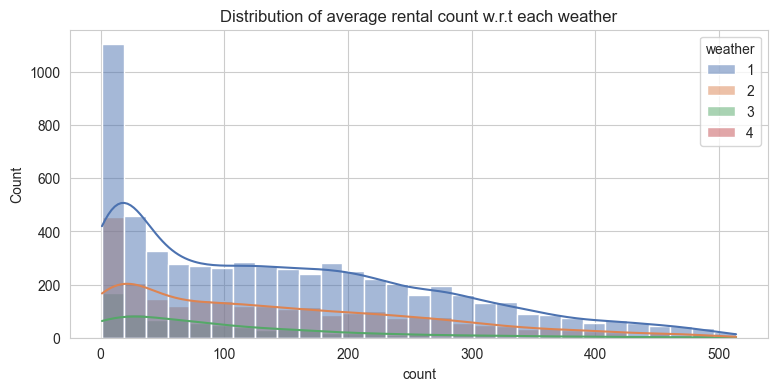

In [81]:
plt.figure(figsize=(9, 4))
sns.histplot(data=yu_df, hue="weather", x="count", kde=True)
plt.title("Distribution of average rental count w.r.t each weather")
plt.show()

##### Normality check using Q-Q Plot

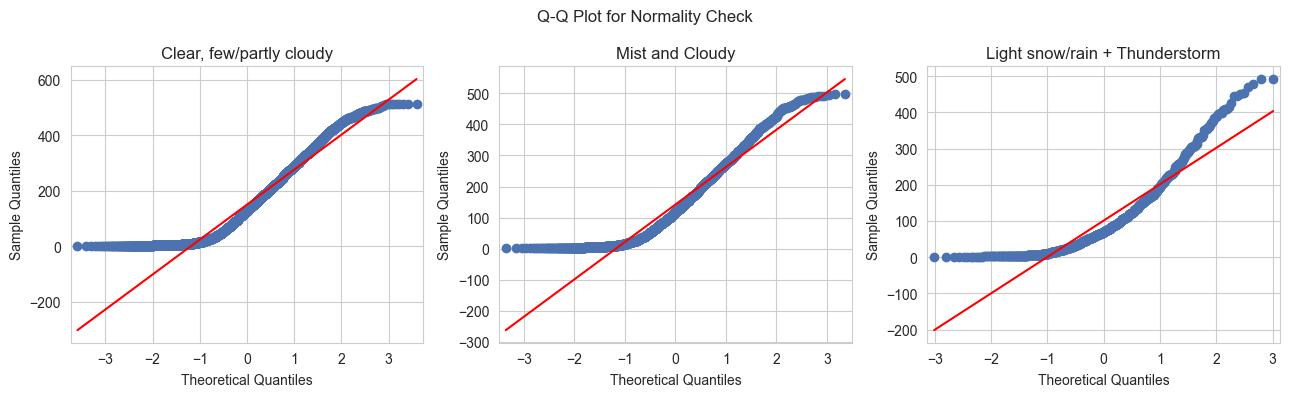

In [82]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(13, 4))

# Q-Q plot for Normal data
sm.qqplot(w1_count.values, line="s", ax=axes[0])
axes[0].set_title("Clear, few/partly cloudy")

# Q-Q plot for Exponential data
sm.qqplot(w2_count.values, line="s", ax=axes[1])
axes[1].set_title("Mist and Cloudy")

# Q-Q plot for t-distribution data
sm.qqplot(w3_count.values, line="s", ax=axes[2])
axes[2].set_title("Light snow/rain + Thunderstorm")

plt.suptitle("Q-Q Plot for Normality Check")
plt.tight_layout()
plt.show()

##### Normality check using Shapiro-Wilkis Test

For each category of weather condition perform Shapiro-Wilkis Test for Normality.

- $H_0$ : Distribution of rental-count in clear weather is normally distributed.
- $H_a$ : Distribution of rental-count in clear weather is not normally distributed.

In [83]:
shapiro_test(w1_count.sample(2500).values)

W-statistic: 0.9208984382080349
p-value: 2.395492589963401e-34
Reject Null-Hypothesis. Distribution is not Gaussian.


- $H_0$ : Distribution of rental-count in misty and cloudy weather is normally distributed.
- $H_a$ : Distribution of rental-count in misty and cloudy weather is not normally distributed.

In [84]:
shapiro_test(w2_count.values)

W-statistic: 0.9164805276691838
p-value: 2.748856121990955e-35
Reject Null-Hypothesis. Distribution is not Gaussian.


- $H_0$ : Distribution of rental-count in snowy/rainy weather is normally distributed.
- $H_a$ : Distribution of rental-count in snowy/rainy weather is not normally distributed.

In [85]:
shapiro_test(w3_count.values)

W-statistic: 0.850701056707974
p-value: 2.417666046396992e-26
Reject Null-Hypothesis. Distribution is not Gaussian.


##### Homogeneous Variance

Perform levene's test for equality of variance.

- $H_0$ : Variances in rental-count across all weather conditions are equal.
- $H_a$ : Rental-count of at least one of the weather has different Variance.

In [86]:
levene_test(w1_count.values, w2_count.values, w3_count.values)

Test-statistic: 58.591323761645285
p-value: 5.153228368533525e-26
Reject Null-Hypothesis. At least one of the sample has different Variance.


#### One-way ANOVA test

##### STEP 1: Formulate Null and Alternate Hypothesis

1. $H_0$ : Average number of bikes rented is same across all weather conditions.
2. $H_a$ : Average number of bikes rented is different in at least one of the weather condition.

##### STEP 2: Select Test-statistic and Significance level

1. For One-way ANOVA, test-statistic is F-Ratio.
2. Significance level is set to 0.05.

In [87]:
alpha = 0.05

##### STEP 3: Select type of test: Left / Right / Two-tailed

In a one-way ANOVA, the test is always right-tailed.

##### STEP 4: Calculate test Statistics and p-value

In [88]:
test_stat, p_value = f_oneway(w1_count.values, w2_count.values, w3_count.values, w4_count.values)
print("F-ratio:", test_stat.item())
print("p-value:", p_value.item())

F-ratio: 37.2968446919463
p-value: 5.956293557893769e-24


##### STEP 5: Compare p-value with Significance level

In [89]:
if p_value < alpha:
    print("Reject Null Hypothesis.")
else:
    print("Failed to reject Null Hypothesis.")

Reject Null Hypothesis.


#### Inference

1. We have enough evidence to reject the null hypothesis.
2. Average number of bikes rented is different in at least one of the weather condition.

#### Kruskal-Wallis test

Since rental count data is not Normally distributed lets perform Kruskal-Wallis test.

##### STEP 1: Formulate Null and Alternate Hypothesis

1. $H_0$ : Average number of bikes rented is same across all weather conditions.
2. $H_a$ : Average number of bikes rented is different in at least one of the weather condition.

##### STEP 2: Select Test-statistic and Significance level

1. For Kruskal-Wallis, test-statistic is H-Statistic.
2. Significance level is set to 0.05.

In [90]:
alpha = 0.05

##### STEP 3: Select type of test: Left / Right / Two-tailed

In Kruskal-Wallis, the test is always right-tailed ch-squared test.

##### STEP 4: Calculate test Statistics and p-value

In [91]:
test_stat, p_value = kruskal(w1_count.values, w2_count.values, w3_count.values, w4_count.values)
print("H-Statistic:", test_stat.item())
print("p-value:", p_value.item())

H-Statistic: 104.06612173459409
p-value: 2.0750962157884824e-22


##### STEP 5: Compare p-value with Significance level

In [92]:
if p_value < alpha:
    print("Reject Null Hypothesis.")
else:
    print("Failed to reject Null Hypothesis.")

Reject Null Hypothesis.


### 7.4 Count vs Seasons

Check if the demand of bicycles on rent is the same for different Seasons?

#### Sampling

In [93]:
# Filter rental count for each season.
mask = yu_df["season"] == 1
s1_count = yu_df[mask]["count"]

mask = yu_df["season"] == 2
s2_count = yu_df[mask]["count"]

mask = yu_df["season"] == 3
s3_count = yu_df[mask]["count"]

mask = yu_df["season"] == 4
s4_count = yu_df[mask]["count"]

#### Check ANOVA Assumptions

##### Normality check using Histogram

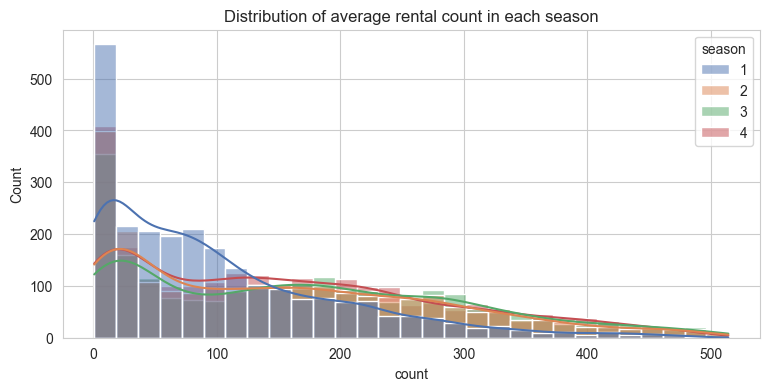

In [94]:
plt.figure(figsize=(9, 4))
sns.histplot(data=yu_df, hue="season", x="count", kde=True)
plt.title("Distribution of average rental count in each season")
plt.show()

##### Normality check using Q-Q Plot

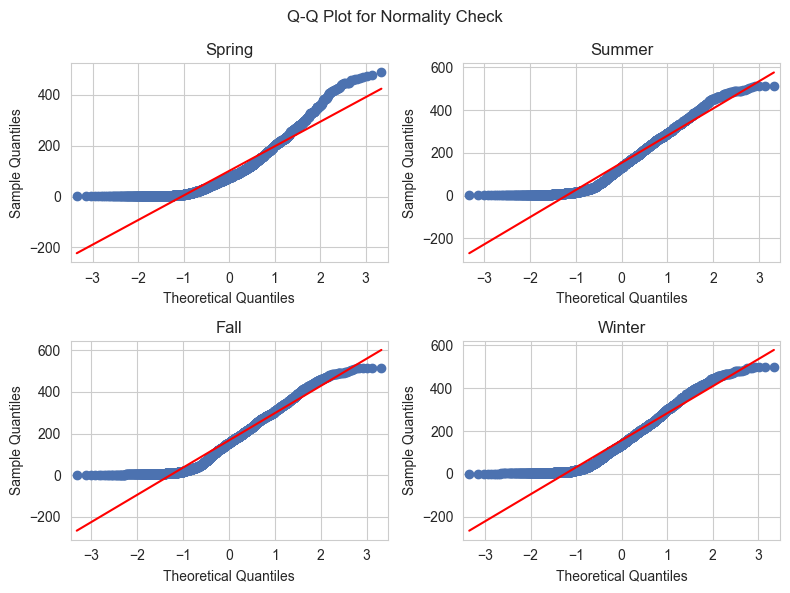

In [95]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 6))

# Q-Q plot of count distribution in spring season.
sm.qqplot(s1_count.values, line="s", ax=axes[0, 0])
axes[0, 0].set_title("Spring")

# Q-Q plot of count distribution in summer season.
sm.qqplot(s2_count.values, line="s", ax=axes[0, 1])
axes[0, 1].set_title("Summer")

# Q-Q plot of count distribution in fall season.
sm.qqplot(s3_count.values, line="s", ax=axes[1, 0])
axes[1, 0].set_title("Fall")

# Q-Q plot of count distribution in winter season.
sm.qqplot(s4_count.values, line="s", ax=axes[1, 1])
axes[1, 1].set_title("Winter")

plt.suptitle("Q-Q Plot for Normality Check")
plt.tight_layout()
plt.show()

##### Normality check using Shapiro-Wilkis Test

For each category of season condition perform Shapiro-Wilkis Test for Normality.

- $H_0$ : Distribution of rental-count in spring season is normally distributed.
- $H_a$ : Distribution of rental-count in spring season is not normally distributed.

In [96]:
shapiro_test(s1_count.values)

W-statistic: 0.8714253585386237
p-value: 5.798556558749876e-41
Reject Null-Hypothesis. Distribution is not Gaussian.


- $H_0$ : Distribution of rental-count in summer season is normally distributed.
- $H_a$ : Distribution of rental-count in summer season is not normally distributed.

In [97]:
shapiro_test(s2_count.values)

W-statistic: 0.9231074268917904
p-value: 1.9199006093383038e-32
Reject Null-Hypothesis. Distribution is not Gaussian.


- $H_0$ : Distribution of rental-count in fall season is normally distributed.
- $H_a$ : Distribution of rental-count in fall season is not normally distributed.

In [98]:
shapiro_test(s3_count.values)

W-statistic: 0.9370627554271664
p-value: 9.587226982050262e-30
Reject Null-Hypothesis. Distribution is not Gaussian.


- $H_0$ : Distribution of rental-count in winter season is normally distributed.
- $H_a$ : Distribution of rental-count in winter season is not normally distributed.

In [99]:
shapiro_test(s4_count.values)

W-statistic: 0.9301729387433578
p-value: 2.627416259075925e-32
Reject Null-Hypothesis. Distribution is not Gaussian.


##### Homogeneous Variance

Perform levene's test for equality of variance.

- $H_0$ : Variances in rental-count across all seasons are equal.
- $H_a$ : Rental-count of at least one of the season has different Variance.

In [100]:
levene_test(s1_count.values, s2_count.values, s3_count.values, s4_count.values)

Test-statistic: 134.92207742468392
p-value: 1.4156739715299946e-85
Reject Null-Hypothesis. At least one of the sample has different Variance.


#### One-way ANOVA test

##### STEP 1: Formulate Null and Alternate Hypothesis

1. $H_0$ : Average number of bikes rented is same in all seasons
2. $H_a$ : Average number of bikes rented is different in at least one season

##### STEP 2: Select Test-statistic and Significance level

1. For One-way ANOVA, test-statistic is F-Ratio.
2. Significance level is set to 0.05.

In [101]:
alpha = 0.05

##### STEP 3: Select type of test: Left / Right / Two-tailed

In a one-way ANOVA, the test is always right-tailed.

##### STEP 4: Calculate test Statistics and p-value

In [102]:
test_stat, p_value = f_oneway(s1_count.values, s2_count.values, s3_count.values, s4_count.values)
print("F-ratio:", test_stat.item())
print("p-value:", p_value.item())

F-ratio: 148.06214819202174
p-value: 9.583582124778882e-94


##### STEP 5: Compare p-value with Significance level

In [103]:
if p_value < alpha:
    print("Reject Null Hypothesis.")
else:
    print("Failed to reject Null Hypothesis.")

Reject Null Hypothesis.


#### Inference

1. We have enough evidence to reject the null hypothesis.
2. Average number of bikes rented is different in at least one season.

#### Kruskal-Wallis test

Since rental count data is not Normally distributed lets perform Kruskal-Wallis test.

##### STEP 1: Formulate Null and Alternate Hypothesis

1. $H_0$ : Average number of bikes rented is same in all seasons
2. $H_a$ : Average number of bikes rented is different in at least one season

##### STEP 2: Select Test-statistic and Significance level

1. For Kruskal-Wallis, test-statistic is H-Statistic.
2. Significance level is set to 0.05.

In [104]:
alpha = 0.05

##### STEP 3: Select type of test: Left / Right / Two-tailed

In Kruskal-Wallis, the test is always right-tailed ch-squared test.

##### STEP 4: Calculate test Statistics and p-value

In [105]:
test_stat, p_value = kruskal(s1_count, s2_count, s3_count, s4_count)
print("H-Statistic:", test_stat.item())
print("p-value:", p_value.item())

H-Statistic: 402.42037461467095
p-value: 6.620353865032859e-87


##### STEP 5: Compare p-value with Significance level

In [106]:
if p_value < alpha:
    print("Reject Null Hypothesis.")
else:
    print("Failed to reject Null Hypothesis.")

Reject Null Hypothesis.


### 7.5 Weather vs Seasons

Check if the Weather conditions are significantly different during different Seasons?

#### Sampling

In [107]:
# weather-season contingency table.
ws_ct = pd.crosstab(
    index=yu_df["weather"],
    columns=yu_df["season"],
    margins=True,
    margins_name="Total",
).round(2)

ws_ct

season,1,2,3,4,Total
weather,,,,,
1,1583,1436,1557,1483,6059
2,680,610,500,743,2533
3,184,203,173,211,771
4,1,0,0,0,1
Total,2448,2249,2230,2437,9364


In [108]:
observed_vals = ws_ct.values[:-1, :-1]
observed_vals

array([[1583, 1436, 1557, 1483],
       [ 680,  610,  500,  743],
       [ 184,  203,  173,  211],
       [   1,    0,    0,    0]])

#### Chi-Squared test of independence

##### STEP 1: Formulate Null and Alternate Hypothesis

- $H_0$ : Weather conditions are different during different seasons
- $H_a$ : Weather conditions depends on seasons

##### STEP 2: Select Test-statistic and Significance level

1. For Chi-Squared test of independence, test-statistic is chi-squared statistic.
2. Significance level is set to 0.05.

In [109]:
alpha = 0.05

##### STEP 3: Select type of test: Left / Right / Two-tailed

In a Chi-Squared, the test is always right-tailed.

##### STEP 4: Calculate test Statistics and p-value

In [110]:
test_stat, p_value, _, _ = chi2_contingency(observed_vals)
print("Chi-Squared statistic:", test_stat.round(6).item())
print("p-value:", p_value.item())

Chi-Squared statistic: 50.872763
p-value: 7.37899576712981e-08


##### STEP 5: Compare p-value with Significance level

In [111]:
if p_value < alpha:
    print("Reject Null Hypothesis. Weather conditions depends on seasons.")
else:
    print("Failed to reject Null Hypothesis.")

Reject Null Hypothesis. Weather conditions depends on seasons.


#### Inference

1. We have evidence to reject the null hypothesis.
2. Weather conditions depends on seasons.

## 8 Conclusion

### 8.1 Dataset Insights

1. Dataset contains details of approximately 10,000 bike rental details of casual and registered customers.
1. Dataset has two years bike rental details captured between 01-Jan-2011 and 19-Dec-2012.
1. Median bike rental count appears to be same in summer, fall and winter season.
1. Median bike rental count appears to be less in spring season compared to other seasons.
1. Median bike rental count appears to be same in good weather conditions like clear sky, less cloud and mist.
1. Median bike rental count appears to be less in moderate weather conditions like snowing and raining.
1. As temperature increases average bike rental count increases.
1. As humidity increases average bike rental count decreases.

### 8.2 Business Insights

#### Weather Insights

1. 65% of rentals recorded clear weather with few clouds.
2. 27% of rentals recorded misty and cloudy weather.
3. 8% of rentals recorded snow, rain and/or thunderstorm.
4. less than 1% of rentals recorded harsh weather conditions.
5. In every season average bike rentals are high when the weather is clear and fewer clouds.
6. In every season average bike rentals are low when it is snowing or raining.
7. In Spring season, there was a very high demand on one specific day when the weather condition was very bad with heavy rain and thunderstorm.

#### Bike Usage Insights

1. On an average approximately 2200 plus bikes are rented every season.
1. Rental bikes have constant demand in every season.
1. 97% of bike rentals happen on non holidays.
1. Only 3% of bike rentals happen on holidays.
1. 71% of rentals were recorded on working day
1. 29% of rentals were recorded on weekends or holidays.

#### User Insights

1. On an average 24 bikes are used by casual users in any given hour.
2. Maximum of 116 bikes gets rented by casual users in one hour.
3. On an average 120 bikes are used by registered users in any given hour.
4. Maximum of 458 bikes gets rented by registered users in one hour.
5. Overall on an average of 143 bikes are used by users in any given hour.
6. Maximum of 500 bikes gets rented by users in one hour.

### 8.4 Insights from Hypothesis Testing

1. The average number of bike rides on weekdays and weekends are significantly different.
2. Average number of bikes rented is different in at least one of the weather condition.
3. Average number of bikes rented is different in at least one season.
4. Weather conditions depends on seasons.

### 8.5 Recommendations

1. On weekends demand for rental bikes is very low between 11 AM in the morning to 5 PM in the evening.
2. On weekdays demand for rental bikes is very low in two time frames:
    1. Between 8 AM and 9 AM in the morning
    2. Between 5 PM and 7 PM in the evening.